In [9]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from mesa import Agent, Model
from mesa.time import RandomActivation
from IPython.display import display, clear_output
import matplotlib.animation as animation
import pygame

pygame 2.6.1 (SDL 2.28.4, Python 3.12.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Load the road network for Los Angeles
G = ox.graph_from_place("Los Angeles, California, USA", network_type="drive")
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
ox.save_graphml(G, "los_angeles.graphml")

print("Graph loaded with", len(G.nodes), "nodes and", len(G.edges), "edges.")

Graph loaded with 49472 nodes and 135842 edges.


In [10]:
pygame.init()
WIDTH, HEIGHT = 800, 800
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Los Angeles Mobility Simulation")
clock = pygame.time.Clock()

graph_filename = "los_angeles.graphml"

try:
    G = ox.load_graphml(graph_filename)
    print("Loaded graph from cache.")
except FileNotFoundError:
    print("Cached graph not found. Downloading and caching...")
    G = ox.graph_from_place("Los Angeles, California, USA", network_type="drive")
    G = ox.add_edge_speeds(G)
    G = ox.add_edge_travel_times(G)
    ox.save_graphml(G, graph_filename)
    print("Graph cached successfully!")

def convert_to_screen(lat, lon):
    """Convert geographic coordinates to Pygame screen coordinates."""
    min_lat, max_lat = 34.0, 34.3
    min_lon, max_lon = -118.5, -118.1
    x = int((lon - min_lon) / (max_lon - min_lon) * WIDTH)
    y = int((max_lat - lat) / (max_lat - min_lat) * HEIGHT)
    return x, y

class MobilityAgent(Agent):
    def __init__(self, unique_id, model, start_node, end_node, path):
        super().__init__(unique_id, model)
        self.current_index = 0
        self.path = path
        self.start_node = start_node
        self.end_node = end_node

    def move(self):
        """Move the agent along its shortest path."""
        if self.current_index < len(self.path) - 1:
            self.current_index += 1  # Move forward one step

    def get_position(self):
        """Get the agent's current position (lat, lon)."""
        node = self.path[self.current_index]
        return G.nodes[node]["y"], G.nodes[node]["x"]

class MobilityModel(Model):
    def __init__(self, num_agents):
        super().__init__()
        self.schedule = RandomActivation(self)
        self.agents = []

        for i in range(num_agents):
            start_node = random.choice(list(G.nodes))  # Random start node
            end_node = random.choice(list(G.nodes))  # Random destination node
            path = nx.shortest_path(G, start_node, end_node, weight="travel_time")

            agent = MobilityAgent(i, self, start_node, end_node, path)
            self.schedule.add(agent)
            self.agents.append(agent)

    def step(self):
        """Advance the simulation by moving all agents."""
        for agent in self.agents:
            agent.move()  # Move the agent along its path


num_agents = 20
model = MobilityModel(num_agents)


running = True
while running:
    screen.fill((255, 255, 255))  # Clear screen

    # Draw Road Network
    for u, v, data in G.edges(data=True):
        x1, y1 = convert_to_screen(G.nodes[u]["y"], G.nodes[u]["x"])
        x2, y2 = convert_to_screen(G.nodes[v]["y"], G.nodes[v]["x"])
        pygame.draw.line(screen, (200, 200, 200), (x1, y1), (x2, y2), 1)

    # Move Agents & Draw Them
    model.step()
    for agent in model.agents:
        lat, lon = agent.get_position()
        x, y = convert_to_screen(lat, lon)
        pygame.draw.circle(screen, (0, 0, 255), (x, y), 5)  # Draw agent

    pygame.display.flip()  # Update display
    clock.tick(60)  # Run at 30 FPS

    # Handle Quit Event
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

pygame.quit()

Loaded graph from cache.


In [9]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("la.csv")
#filtered_df = df[df["place_id"] == "ChIJMc1kAdMq3YARKjm9z9YofYM"]
df.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,US,United States,California,Los Angeles County,NaN,NaN,6037,ChIJMc1kAdMq3YARKjm9z9YofYM,01-01-2022,-47,-38,-35,-52,-55,14
1,US,United States,California,Los Angeles County,NaN,NaN,6037,ChIJMc1kAdMq3YARKjm9z9YofYM,02-01-2022,-25,-19,-26,-35,-22,7
2,US,United States,California,Los Angeles County,NaN,NaN,6037,ChIJMc1kAdMq3YARKjm9z9YofYM,03-01-2022,-20,-9,-27,-38,-45,12
3,US,United States,California,Los Angeles County,NaN,NaN,6037,ChIJMc1kAdMq3YARKjm9z9YofYM,04-01-2022,-24,-10,-28,-40,-41,12
4,US,United States,California,Los Angeles County,NaN,NaN,6037,ChIJMc1kAdMq3YARKjm9z9YofYM,05-01-2022,-24,-9,-27,-41,-41,13


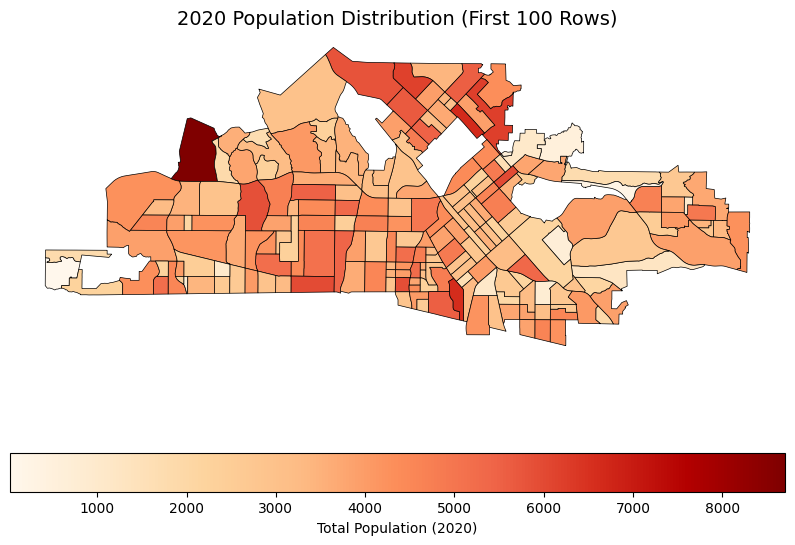

(2879, 46)


In [7]:
import geopandas as gpd
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
shapefile_path = "E:/temp/2020_Population/2020_Population_and_Poverty_at_Split_Tract.shp"
gdf = gpd.read_file(shapefile_path)

# Set display options to show all rows and columns
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.max_colwidth", None)  # Do not truncate column contents
pd.set_option("display.expand_frame_repr", False)  # Prevent wrapping into multiple lines
# pd.reset_option("display.max_rows")
# pd.reset_option("display.max_columns")
# pd.reset_option("display.max_colwidth")
# pd.reset_option("display.expand_frame_repr")

# Display the entire GeoDataFrame
gdf.head(1)

# Load the shapefile
shapefile_path = "E:/temp/2020_Population/2020_Population_and_Poverty_at_Split_Tract.shp"
gdf = gpd.read_file(shapefile_path)

# Select the first 100 rows
gdf_subset = gdf.head(200)

# Plot the population data
fig, ax = plt.subplots(figsize=(10, 8))
gdf_subset.plot(column="POP20_TOTA", cmap="OrRd", linewidth=0.5, edgecolor="black", legend=True, 
                legend_kwds={'label': "Total Population (2020)", 'orientation': "horizontal"}, ax=ax)

ax.set_title("2020 Population Distribution (First 100 Rows)", fontsize=14)
ax.axis("off")  # Hide axis

plt.show()
print(gdf.shape)

In [5]:
import geopandas as gpd
import pandas as pd

shapefile_path = "E:/temp/filtered census data/filtered_population_data.shp"
gdf = gpd.read_file(shapefile_path)
print(gdf.shape)
# Display the entire GeoDataFrame
gdf.head(1)

(2879, 23)


,OBJECTID,CT20FIP20C,HD22,HD_NAME,POP20_AGE_,POP20_AG_1,POP20_AG_2,POP20_AG_3,POP20_AG_4,POP20_AG_5,POP20_AG_6,POP20_AG_7,POP20_AG_8,POP20_AG_9,POP20_AG10,POP20_AG11,POP20_AG12,POP20_AG13,POP20_TOTA,AREA_SQMIL,POP20_DENS,Shape__Are,geometry
0,1,10111044000Tujunga,19,East Valley,223,253,233,134,95,254,349,308,661,667,821,603,234,91,4926,0.441064,11168.438433,12.296168,"POLYGON ((6471651.068 1918306.964, 6471940.821 1918303.923, 6472225.136 1918301.264, 6472330.884 1918299.861, 6472489.81 1918298.302, 6472733.033 1918295.77, 6472776.812 1918181.371, 6473048.131 1918176.939, 6473348.152 1918172.062, 6473647.872 1918167.188, 6474021.312 1918160.65, 6474506.542 1918152.339, 6474760.035 1918147.973, 6475008.692 1918143.623, 6475105.075 1918142.257, 6475329.71 1918084.118, 6475580.01 1918019.358, 6475580.209 1917769.708, 6475581.162 1916933.418, 6475571.148 1916492.012, 6475569.034 1916385.753, 6475560.678 1915996.383, 6475559.641 1915950.168, 6475552.983 1915627.026, 6475267.737 1915630.02, 6474955.9 1915633.092, 6474841.984 1915634.509, 6474453.699 1915638.533, 6474096.235 1915642.109, 6473968.721 1915643.569, 6473720.642 1915646.105, 6473075.818 1915652.71, 6472774.255 1915655.775, 6472725.002 1915656.283, 6472502.002 1915658.392, 6472379.625 1915659.844, 6472217.362 1915661.413, 6472107.977 1915662.463, 6471932.721 1915664.436, 6471643.245 1915667.476, 6471180.384 1915672.126, 6470945.621 1915943.974, 6470720.099 1916205.896, 6470325.077 1916664.161, 6470747.751 1916661.582, 6470768.428 1916671.225, 6470779.448 1916693.3, 6470780.834 1916979.792, 6470790.85 1916994.683, 6470793.264 1918306.607, 6470779.733 1918328.483, 6471651.068 1918306.964))"


In [6]:
# import geopandas as gpd
# import numpy as np
# from libpysal.weights import Queen
# from spopt.region import Skater
# from sklearn.preprocessing import StandardScaler

# # Load the dataset and reproject to a metric CRS for spatial calculations
# gdf = gpd.read_file("E:/temp/filtered census data/filtered_population_data.shp")
# gdf = gdf.to_crs(epsg=3857)

# # Create a Queen contiguity spatial weights matrix with explicit use_index to avoid warnings.
# w = Queen.from_dataframe(gdf, use_index=False)

# # Check for islands and drop them so the weights matrix is fully connected.
# if len(w.islands) > 0:
#     print("Found islands in the weights matrix. Dropping them for clustering.")
#     gdf = gdf[~gdf.index.isin(w.islands)]
#     # Recompute the weights matrix after dropping islands.
#     w = Queen.from_dataframe(gdf, use_index=False)

# # Create scaled attribute columns for clustering.
# scaler = StandardScaler()
# scaled_attrs = scaler.fit_transform(gdf[['POP20_TOTA', 'AREA_SQMIL']])
# gdf['POP20_TOTA_scaled'] = scaled_attrs[:, 0]
# gdf['AREA_SQMIL_scaled'] = scaled_attrs[:, 1]

# # Apply the Skater algorithm to produce 20 contiguous clusters.
# # Here, n_clusters=20 specifies that we want 20 regions.
# # The attrs_name parameter now uses the names of the scaled columns.
# skater_model = Skater(gdf, w, n_clusters=20, attrs_name=['POP20_TOTA_scaled', 'AREA_SQMIL_scaled'])
# skater_model.solve()
# gdf['region'] = skater_model.labels_

# # (Optional) Check distribution of clusters
# print(gdf['region'].value_counts())

# # Define fields to aggregate (only numeric fields that make sense to sum)
# fields_to_keep = [
#     "POP20_AGE_", "POP20_AG_1", "POP20_AG_2", "POP20_AG_3", "POP20_AG_4", 
#     "POP20_AG_5", "POP20_AG_6", "POP20_AG_7", "POP20_AG_8", "POP20_AG_9", 
#     "POP20_AG10", "POP20_AG11", "POP20_AG12", "POP20_AG13", "POP20_TOTA", 
#     "POV20_TOTA", "AREA_SQMIL", "Shape__Are"
# ]

# # Create a subset including only aggregable fields plus 'region' and geometry.
# gdf_subset = gdf[["region", "geometry"] + fields_to_keep].copy()

# # Define aggregation functions: for all the above, use "sum"
# agg_funcs = {col: "sum" for col in fields_to_keep}

# # Dissolve the polygons by the 'region' field (aggregating contiguous blocks)
# aggregated_gdf = gdf_subset.dissolve(by="region", aggfunc=agg_funcs)
# aggregated_gdf = aggregated_gdf.reset_index()

# # Recalculate population density as total population divided by area.
# aggregated_gdf["POP20_DENS"] = aggregated_gdf["POP20_TOTA"] / aggregated_gdf["AREA_SQMIL"]

# # Optionally, reproject back to geographic CRS (EPSG:4326) for mapping
# aggregated_gdf = aggregated_gdf.to_crs(epsg=4326)

# # Save the new aggregated shapefile.
# output_path = "E:/temp/aggregated_population_regions_contiguous.shp"
# aggregated_gdf.to_file(output_path)

# print(f"Aggregated shapefile with 20 contiguous regions saved at: {output_path}")

In [1]:
import pygame
import random
import osmnx as ox
import networkx as nx
import geopandas as gpd
from mesa import Model, Agent
from mesa.time import RandomActivation
from shapely.geometry import shape

# Define a bounding box for a subset of Los Angeles (adjust these values as needed)
min_lat, max_lat = 34.05, 34.15  # latitude bounds
min_lon, max_lon = -118.45, -118.35  # longitude bounds
bbox = (max_lat, min_lat, max_lon, min_lon)
# Use the bounding box to fetch a smaller graph from OSM
place = f"{min_lat}, {min_lon}, {max_lat}, {max_lon}"
print("Downloading graph for subset of Los Angeles...")
G = ox.graph_from_bbox(bbox, network_type="drive")
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
print("Graph loaded for subset of Los Angeles.")

# Load population data from shapefile
shapefile_path = r"E:\temp\filtered census data\filtered_population_data.shp"
pop_data = gpd.read_file(shapefile_path)

# Filter population data to only include features within our bounding box
pop_data = pop_data[pop_data.geometry.centroid.within(
    gpd.GeoSeries([gpd.points_from_xy([min_lon, max_lon], [min_lat, max_lat]).unary_union.convex_hull]).unary_union
)]

# Ensure the population density field is available (adjust field name if needed)
if 'POP20_DENS' not in pop_data.columns:
    raise ValueError("Field 'POP20_DENS' not found in the shapefile.")

# Map population density to nearest OSM nodes within the bounding box
pop_density_nodes = []
for _, row in pop_data.iterrows():
    centroid = row['geometry'].centroid
    nearest_node = ox.distance.nearest_nodes(G, centroid.x, centroid.y)
    density = row['POP20_DENS']
    if density > 0:
        pop_density_nodes.append((nearest_node, density))

if not pop_density_nodes:
    raise ValueError("No nodes with valid population density found within the specified bounds.")

# Normalize the density values for weighted sampling
total_density = sum(density for _, density in pop_density_nodes)
pop_density_nodes = [(node, density / total_density) for node, density in pop_density_nodes]

# Function to choose a start node based on population density weights
def get_weighted_random_node():
    nodes_list = [node for node, _ in pop_density_nodes]
    weights = [density for _, density in pop_density_nodes]
    return random.choices(nodes_list, weights=weights, k=1)[0]

# Convert geographic coordinates to Pygame screen coordinates based on our subset bounds
def convert_to_screen(lat, lon):
    x = int((lon - min_lon) / (max_lon - min_lon) * WIDTH)
    y = int((max_lat - lat) / (max_lat - min_lat) * HEIGHT)
    return x, y

class MobilityAgent(Agent):
    def __init__(self, unique_id, model, start_node, end_node, path):
        super().__init__(unique_id, model)
        self.current_index = 0
        self.path = path
        self.start_node = start_node
        self.end_node = end_node

    def move(self):
        if self.current_index < len(self.path) - 1:
            self.current_index += 1

    def get_position(self):
        node = self.path[self.current_index]
        return G.nodes[node]["y"], G.nodes[node]["x"]

class MobilityModel(Model):
    def __init__(self, num_agents):
        super().__init__()
        self.schedule = RandomActivation(self)
        self.agents = []

        for i in range(num_agents):
            start_node = get_weighted_random_node()
            end_node = random.choice(list(G.nodes))
            try:
                path = nx.shortest_path(G, start_node, end_node, weight="travel_time")
            except nx.NetworkXNoPath:
                continue
            agent = MobilityAgent(i, self, start_node, end_node, path)
            self.schedule.add(agent)
            self.agents.append(agent)

    def step(self):
        for agent in self.agents:
            agent.move()

# Use a maximum of 20 agents or less if there are fewer valid population nodes.
num_agents = min(20, len(pop_density_nodes))
model = MobilityModel(num_agents)

pygame.init()
WIDTH, HEIGHT = 800, 800
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Los Angeles Mobility Simulation")
clock = pygame.time.Clock()

running = True
while running:
    screen.fill((255, 255, 255))

    # Draw Road Network
    for u, v, data in G.edges(data=True):
        x1, y1 = convert_to_screen(G.nodes[u]["y"], G.nodes[u]["x"])
        x2, y2 = convert_to_screen(G.nodes[v]["y"], G.nodes[v]["x"])
        pygame.draw.line(screen, (200, 200, 200), (x1, y1), (x2, y2), 1)

    model.step()
    for agent in model.agents:
        lat, lon = agent.get_position()
        x, y = convert_to_screen(lat, lon)
        pygame.draw.circle(screen, (0, 0, 255), (x, y), 5)

    pygame.display.flip()
    clock.tick(60)

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

pygame.quit()

pygame 2.6.1 (SDL 2.28.4, Python 3.12.6)
Hello from the pygame community. https://www.pygame.org/contribute.html
Graph loaded for subset of Los Angeles.


AttributeError: 'function' object has no attribute 'convex_hull'